<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# The Implicit Kinematic Wave Overland Flow Component 

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

## Overview

This notebook demonstrates the `KinwaveImplicitOverlandFlow` Landlab component. The component implements a two-dimensional kinematic wave model of overland flow, using a digital elevation model or other source of topography as the surface over which water flows.

### Theory

The kinematic wave equations are a simplified form of the 2D shallow-water equations in which energy slope is assumed to equal bed slope. Conservation of water mass is expressed in terms of the time derivative of the local water depth, $H$, and the spatial derivative (divergence) of the unit discharge vector $\mathbf{q} = UH$ (where $U$ is the 2D depth-averaged velocity vector):

$$\frac{\partial H}{\partial t} = R - \nabla\cdot \mathbf{q}$$

where $R$ is the local runoff rate [L/T] and $\mathbf{q}$ has dimensions of volume flow per time per width [L$^2$/T]. The discharge depends on the local depth, bed-surface gradient $\mathbf{S}=-\nabla\eta$ (this is the kinematic wave approximation; $\eta$ is land surface height), and a roughness factor $C_r$:

$$\mathbf{q} = \frac{1}{C_r} \mathbf{S} H^\alpha |S|^{-1/2}$$

Reads may recognize this as a form of the Manning, Chezy, or Darcy-Weisbach equation. If $\alpha = 5/3$ then we have the Manning equation, and $C_r = n$ is "Manning's n". If $\alpha = 3/2$ then we have the Chezy/Darcy-Weisbach equation, and $C_r = 1/C = (f/8g)^{1/2}$ represents the Chezy roughness factor $C$ and the equivalent Darcy-Weisbach factor $f$.

### Numerical solution

The solution method used by this component is locally implicit, and works as follows. At each time step, we iterate from upstream to downstream over the topography. Because we are working downstream, we can assume that we know the total water inflow to a given cell. We solve the following mass conservation equation at each cell:

$$\frac{H^{t+1} - H^t}{\Delta t }= \frac{Q_{in}}{A} - \frac{Q_{out}}{A} + R$$

where $H$ is water depth at a given grid node, $t$ indicates time step number, $\Delta t$ is time step duration, $Q_{in}$ is total inflow discharge, $Q_{out}$ is total outflow discharge, $A$ is cell area, and $R$ is local runoff rate (precipitation minus infiltration; could be negative if runon infiltration is occurring).

The specific outflow discharge leaving a cell along one of its faces is:

$$q = (1/C_r) H^\alpha S^{1/2}$$

where $S$ is the downhill-positive gradient of the link that crosses this particular face. Outflow discharge is zero for links that are flat or "uphill" from the given node. Total discharge out of a cell is then the sum of (specific discharge x face width) over all outflow faces:

$$Q_{out} = \sum_{i=1}^N (1/C_r) H^\alpha S_i^{1/2} W_i$$

where $N$ is the number of outflow faces (i.e., faces where the ground slopes downhill away from the cell's node), and $W_i$ is the width of face $i$.

We use the depth at the cell's node, so this simplifies to:

$$Q_{out} = (1/C_r) H'^\alpha \sum_{i=1}^N S_i^{1/2} W_i$$

Notice that we know everything here except $H'$. The reason we know $Q_{out}$ is that it equals $Q_{in}$ (which is either zero or we calculated it previously) plus $RA$.

We define $H$ in the above as a weighted sum of the "old" (time step $t$) and "new" (time step $t+1$) depth values:

$$H' = w H^{t+1} + (1-w) H^t$$

If $w=1$, the method is fully implicit. If $w=0$, it is a simple forward explicit method.

When we combine these equations, we have an equation that includes the unknown $H^{t+1}$ and a bunch of terms that are known. If $w\ne 0$, it is a nonlinear equation in $H^{t+1}$, and must be solved iteratively. We do this using a root-finding method in the scipy.optimize library.

In order to implement the algorithm, we must already know which of neighbors of each node are lower than the neighbor, and what the slopes between them are. We accomplish this using the `FlowAccumulator` and `FlowDirectorMFD` components. Running the `FlowAccumulator` also generates a sorted list (array) of nodes in drainage order.

## Example 1: downpour on a plane

The first example tests that the component can reproduce the expected steady flow pattern on a sloping plane, with a gradient of $S_p$. We'll adopt the Manning equation. Once the system comes into equilibrium, the discharge should increase width distance down the plane according to $q = Rx$. We can use this fact to solve for the corresponding water depth:

$$(1/n) H^{5/3} S^{1/2} = R x$$

which implies

$$H = \left( \frac{nRx}{S^{1/2}} \right)^{3/5}$$

First, import what we'll need:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.components.overland_flow import KinwaveImplicitOverlandFlow
from landlab.io.esri_ascii import read_esri_ascii

Pick the initial and run conditions

In [9]:
# Process parameters
h_init = 0.001  # initial thin layer of water (m)
n = 0.01  # roughness coefficient, (s/m^(1/3))
alpha = 5.0 / 3.0 # depth exponent
S = 0.01 # slope of plane

# Run-control parameters
run_time = 100  # duration of run, (s)
nrows = 5 # number of node rows
ncols = 11 # number of node columns
dx = 2.0 # node spacing, m
dt = 10.0 # time-step size, s

Create grid and fields:


In [10]:
# create and set up grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(False, True, True, True) # open only on east

# add required field
elev = grid.add_zeros('topographic__elevation', at='node')

# set topography
elev[grid.core_nodes] = S * (np.amax(grid.x_of_node) - grid.x_of_node[grid.core_nodes])

Plot topography, first in plan view...

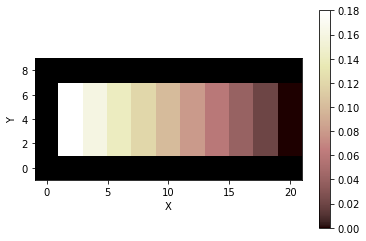

In [11]:
imshow_grid(grid, elev)

...then as a cross-section:

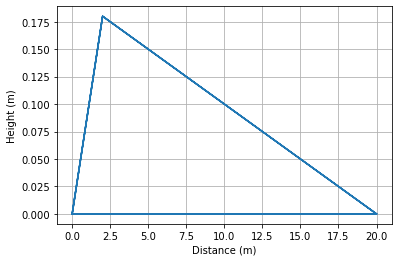

In [15]:
plt.plot(grid.x_of_node, elev)
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')
plt.grid(True)

Elapsed time starts at 1 second. This prevents errors when setting our boundary conditions.

In [ ]:
elapsed_time = 1.0

Use Landlab methods to import an ARC ascii grid, and load the data into the field that the component needs to look at to get the data. This loads the elevation data, z, into a "field" in the grid itself, defined on the nodes.

In [ ]:
rmg, z = read_esri_ascii('Square_TestBasin.asc')
rmg.add_field('topographic__elevation', z, at='node')
rmg.set_closed_boundaries_at_grid_edges(True, True, True, True)

We can get at this data with this syntax:

In [ ]:
np.all(rmg.at_node['topographic__elevation'] == z)

Note that the boundary conditions for this grid mainly got handled with the final line of those three, but for the sake of completeness, we should probably manually "open" the outlet. We can find and set the outlet like this:

In [ ]:
my_outlet_node = 100  # This DEM was generated using Landlab and the outlet node ID was known
rmg.status_at_node[my_outlet_node] = 1  # 1 is the code for fixed value

Now initialize a couple more grid fields that the component is going to need:

In [ ]:
rmg.add_zeros('surface_water__depth', at='node')  # water depth (m)

In [ ]:
rmg.at_node['surface_water__depth'] += h_init

Let's look at our watershed topography

In [ ]:
imshow_grid(rmg, 'topographic__elevation')

Now instantiate the component itself

In [ ]:
of = OverlandFlow(
    rmg, steep_slopes=True
)  #for stability in steeper environments, we set the steep_slopes flag to True

Now we're going to run the loop that drives the component:

In [ ]:
while elapsed_time < run_time:
    # First, we calculate our time step.
    dt = of.calc_time_step()
    # Now, we can generate overland flow.
    of.overland_flow()
    # Increased elapsed time
    print('Elapsed time: ', elapsed_time)
    elapsed_time += dt

In [ ]:
imshow_grid(rmg, 'surface_water__depth', cmap='Blues')

Now let's get clever, and run a set of time slices:

In [ ]:
elapsed_time = 1.
for t in run_time_slices:
    while elapsed_time < t:
        # First, we calculate our time step.
        dt = of.calc_time_step()
        # Now, we can generate overland flow.
        of.overland_flow()
        # Increased elapsed time
        elapsed_time += dt
    figure(t)
    imshow_grid(rmg, 'surface_water__depth', cmap='Blues')

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>